# 0.0 Imports

In [152]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from matplotlib import gridspec
import datetime
from boruta import BorutaPy
import xgboost as xgb
import pickle
import random
import warnings
import json
import requests

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

# 0.1 Helper Functions

In [116]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def cross_validation(x_training, kfold,model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('Kfold number:', k)
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)
        # prediction
        yhat = m.predict(xvalidation)
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])    
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({   
        'Model Name': model_name,
        'MAE CV' : np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
        'MAPE CV' : np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
        'RMSE CV' : np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index =[0])

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))

    return pd.DataFrame( {'Model Name:': model_name, 'MAE':mae, 'MAPE': mape, 'RMSE':rmse}, index=[0])
    
def cramer_v (x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt ((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
591639,360,5,2014-01-17,6153,750,1,0,0,0,a,a,2040.0,6.0,2007.0,0,NaN,NaN,NaN


# 1.0 Descricao dos dados

In [4]:
df1 = df_raw.copy()
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
# test = "AsCasasVaoCair"
# test2 = snakecase(test)
# test2
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
#competition distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [10]:
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [11]:
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [12]:
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [13]:
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [14]:
#promo_interval
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenante
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns= ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

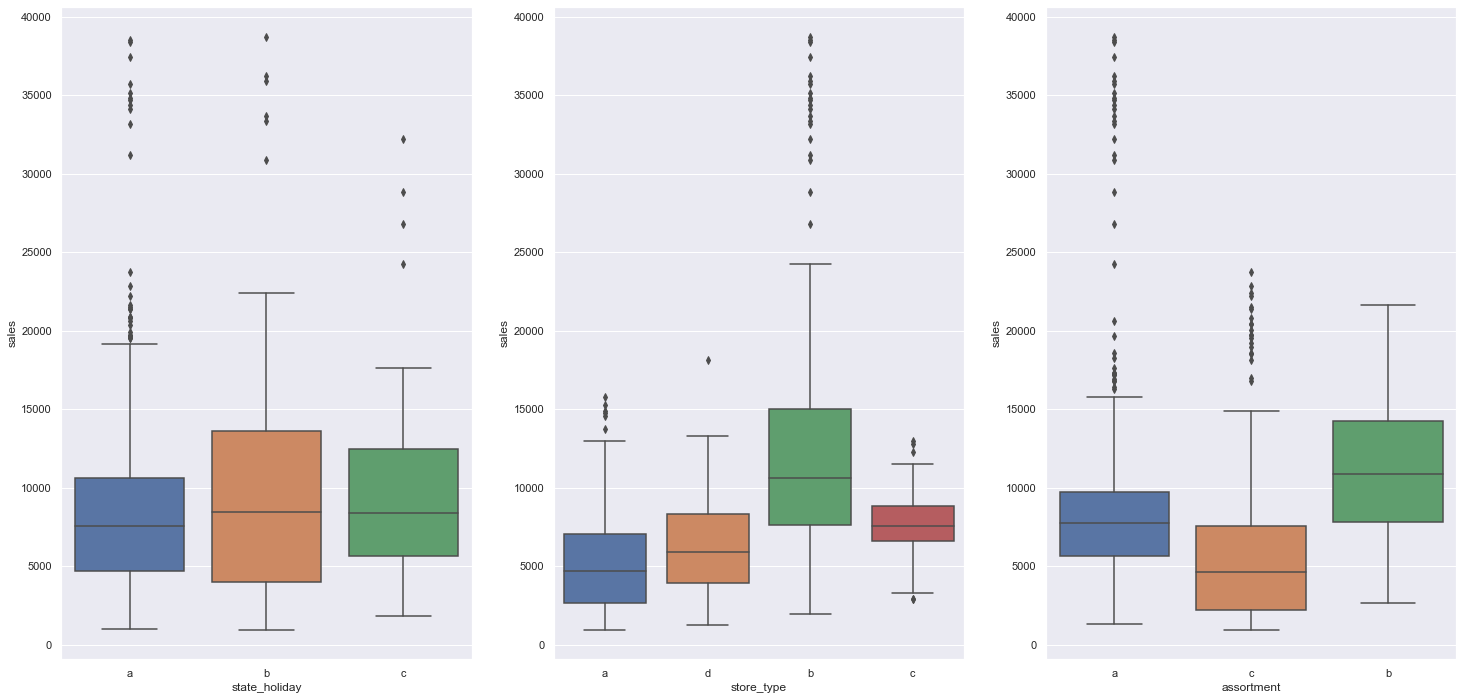

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales',data=aux1)

# 2.0 Feature Enginnering

In [20]:
df2 = df1.copy()

## 2.1 Mind Map Hypotesis

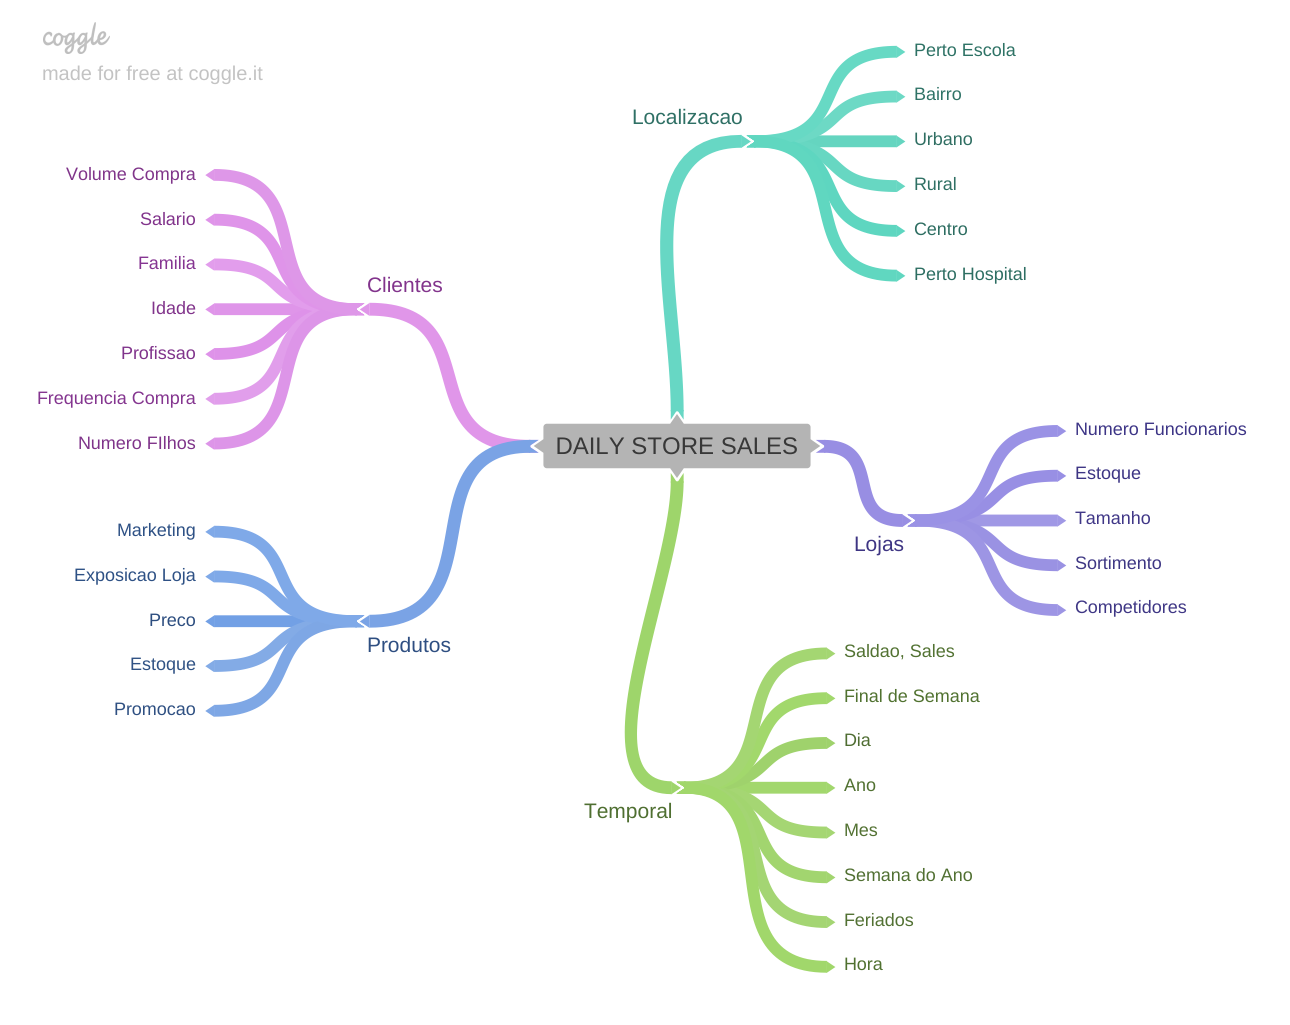

In [21]:
Image('img/mindmaphypotesis.png')

## 2.2 Criacao das Hipoteses

### 2.2.1 Store Hipotesis

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Product Hipotesis

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Temporal Hipotesis

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

## 2.3 Hipotesis Final List

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Enginnering

In [22]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de variaveis

In [24]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao de Colunas

In [26]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Analise Exploratoria dos Dados

In [27]:
df4 = df3.copy()


## 4.1 Analise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

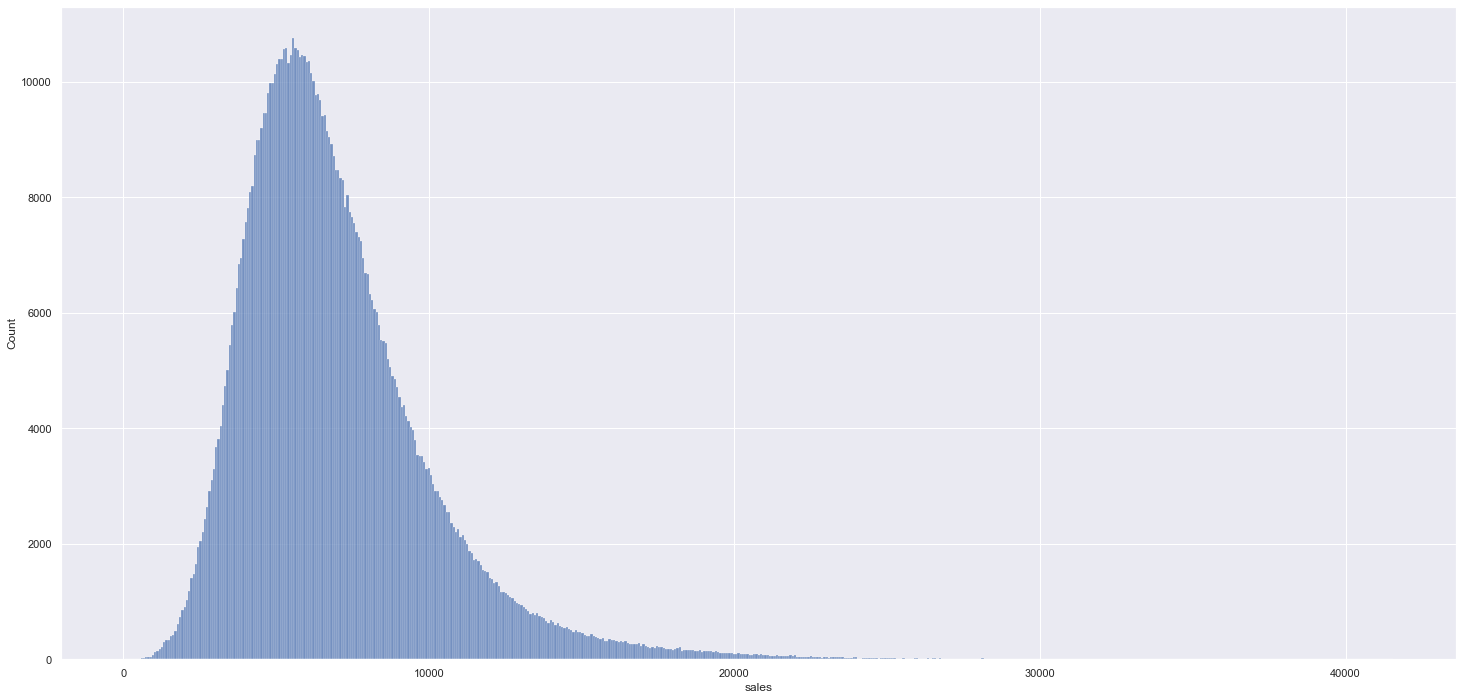

In [28]:
sns.histplot(df4['sales'],kde=False)

### 4.1.2 Numerical Variable

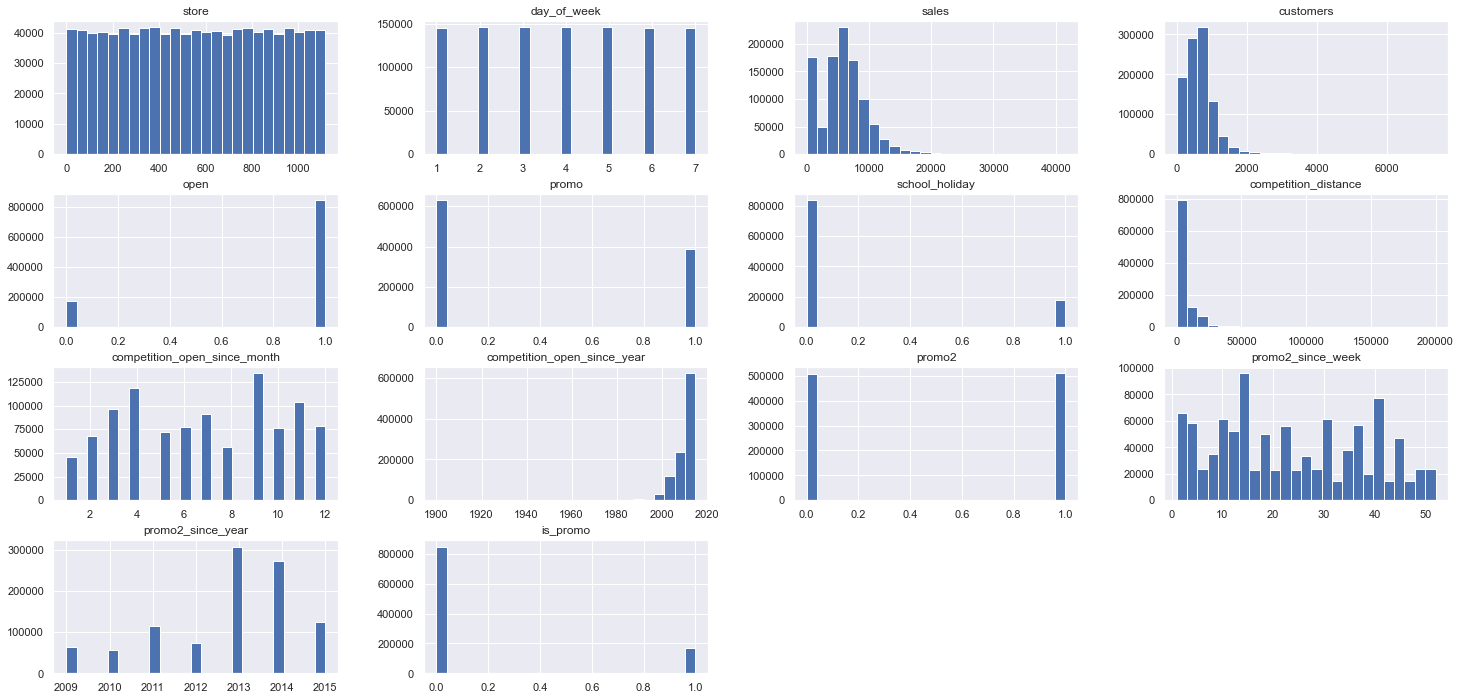

In [29]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [30]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


C:\Users\gusta\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gusta\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gusta\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

<AxesSubplot:xlabel='sales', ylabel='Density'>

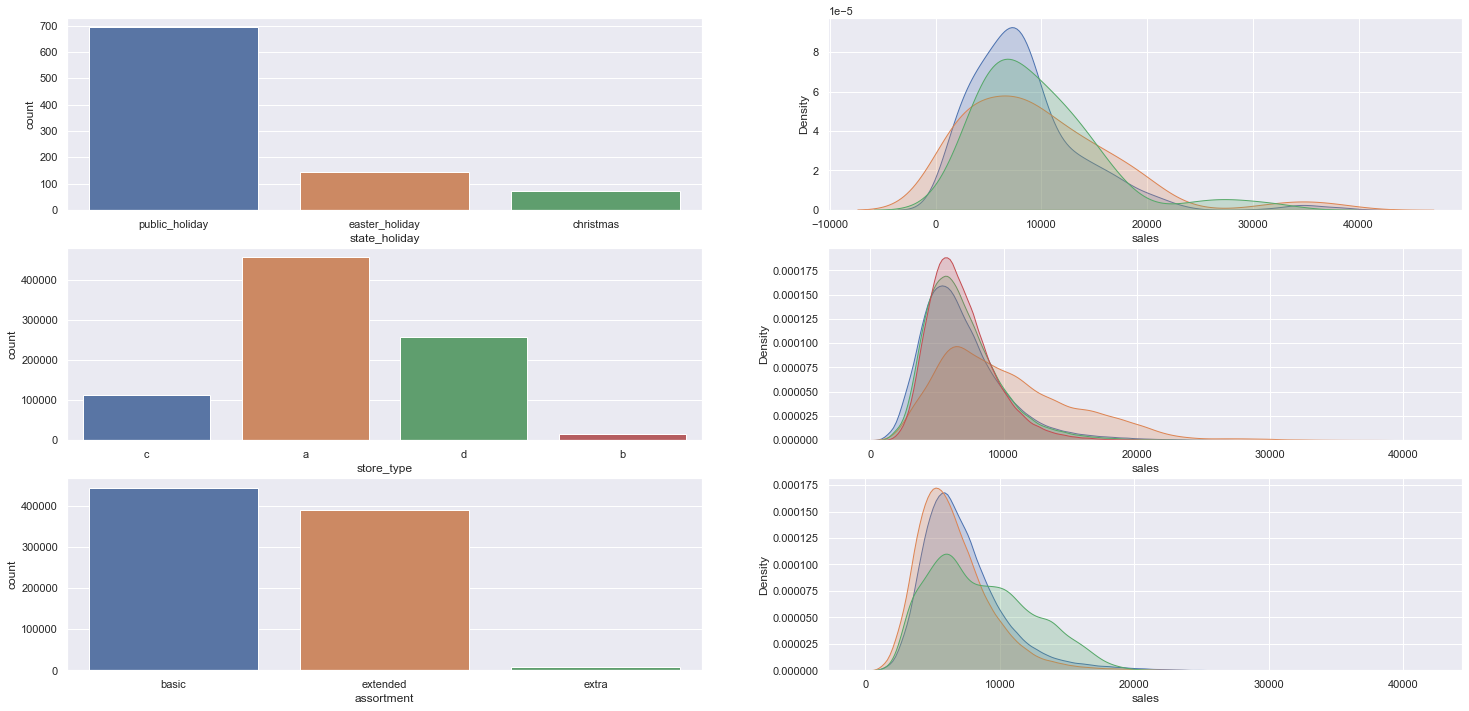

In [31]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True, legend=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True, legend=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True, legend=True )
# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )



## 4.2 Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

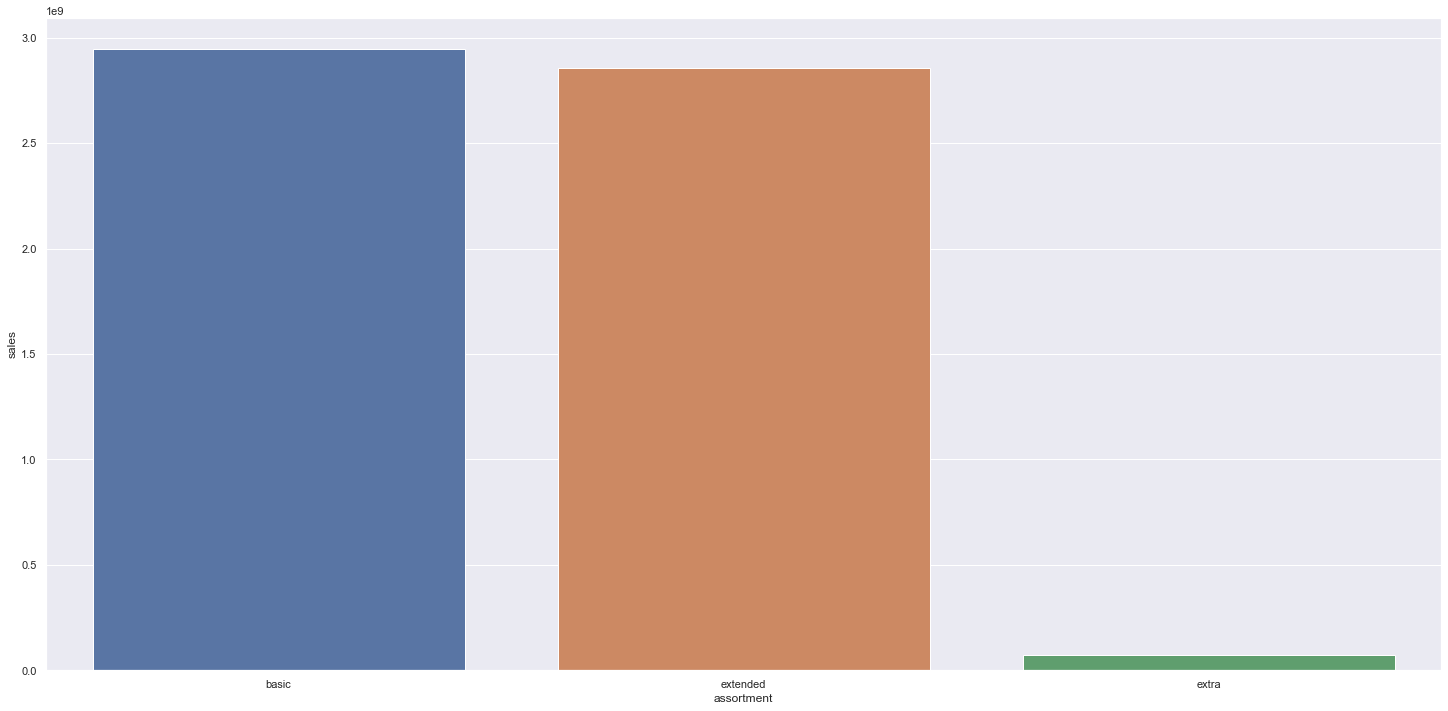

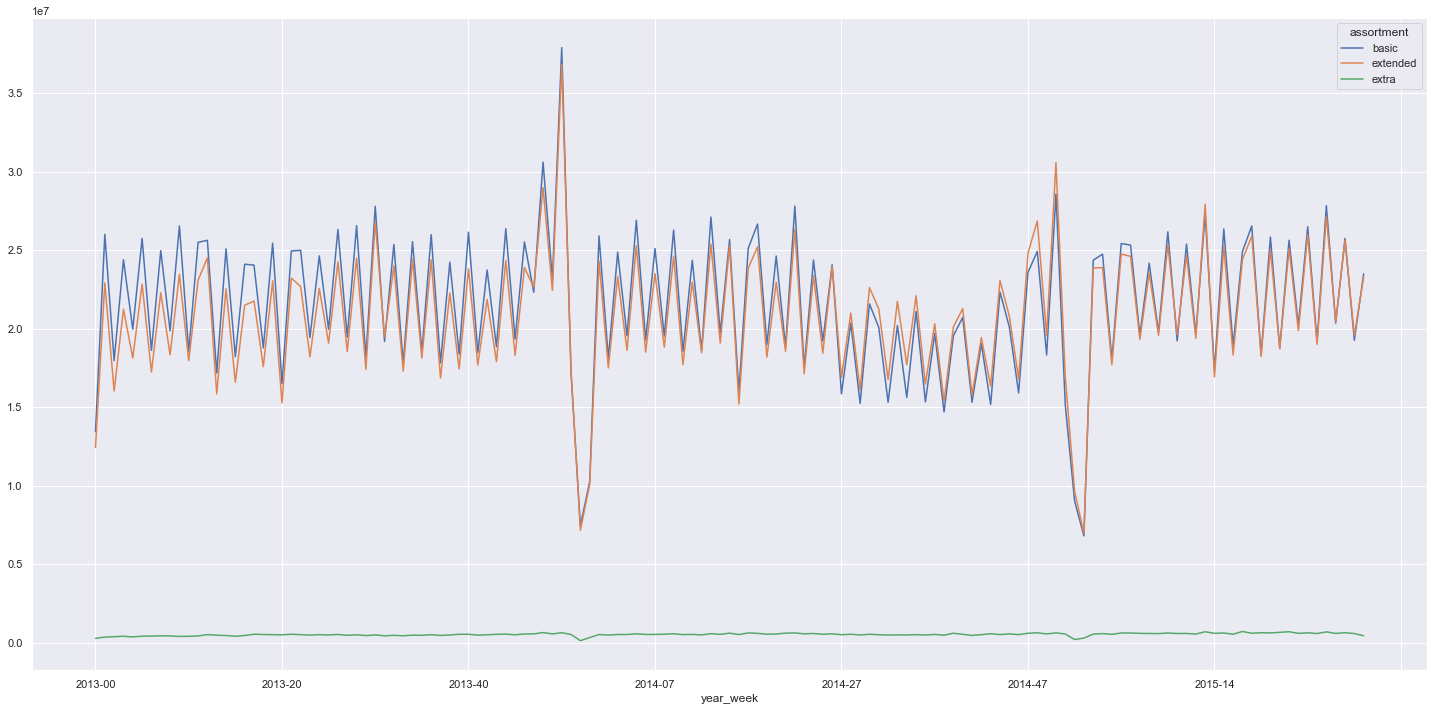

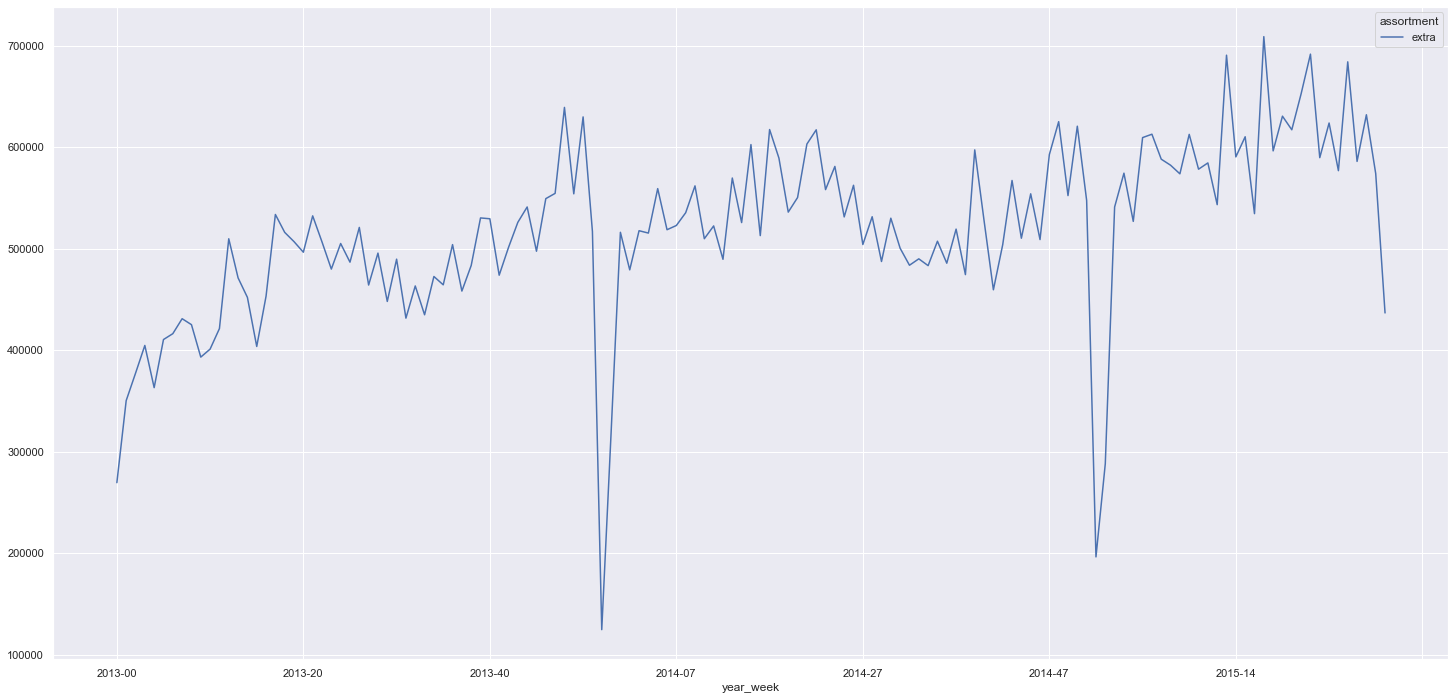

In [32]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais proximos vendem mais

<AxesSubplot:>

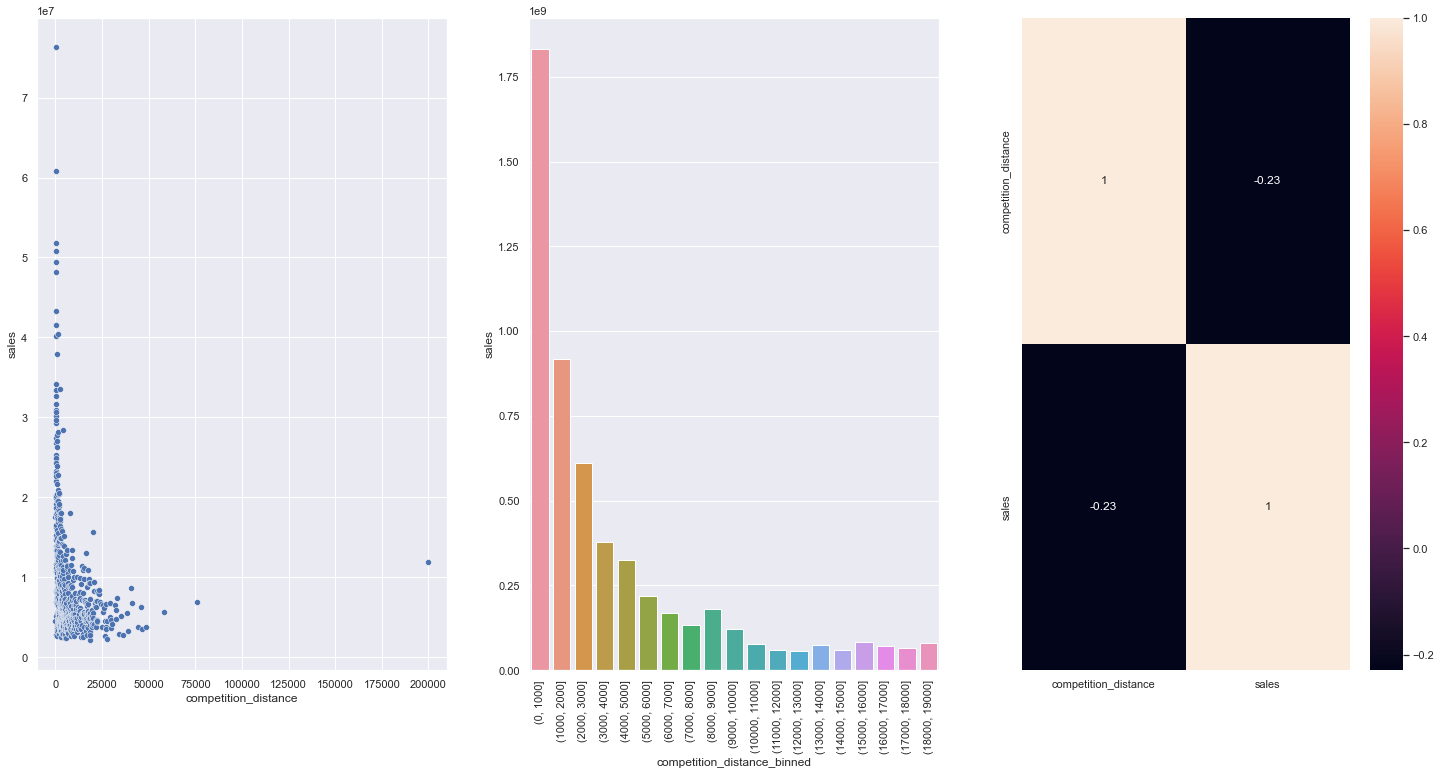

In [33]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales',data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com competidores a mais tempo vendem menos

<AxesSubplot:>

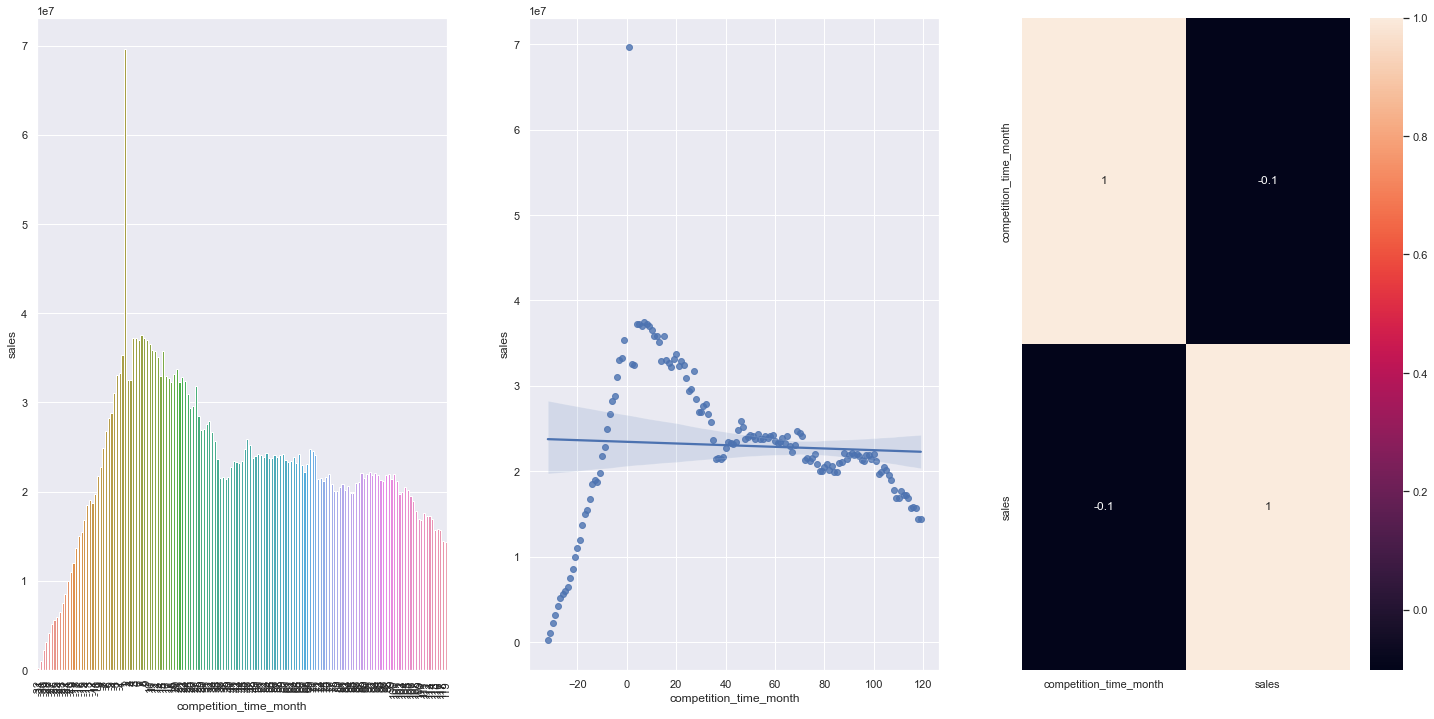

In [34]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos apos um periodo de promocao

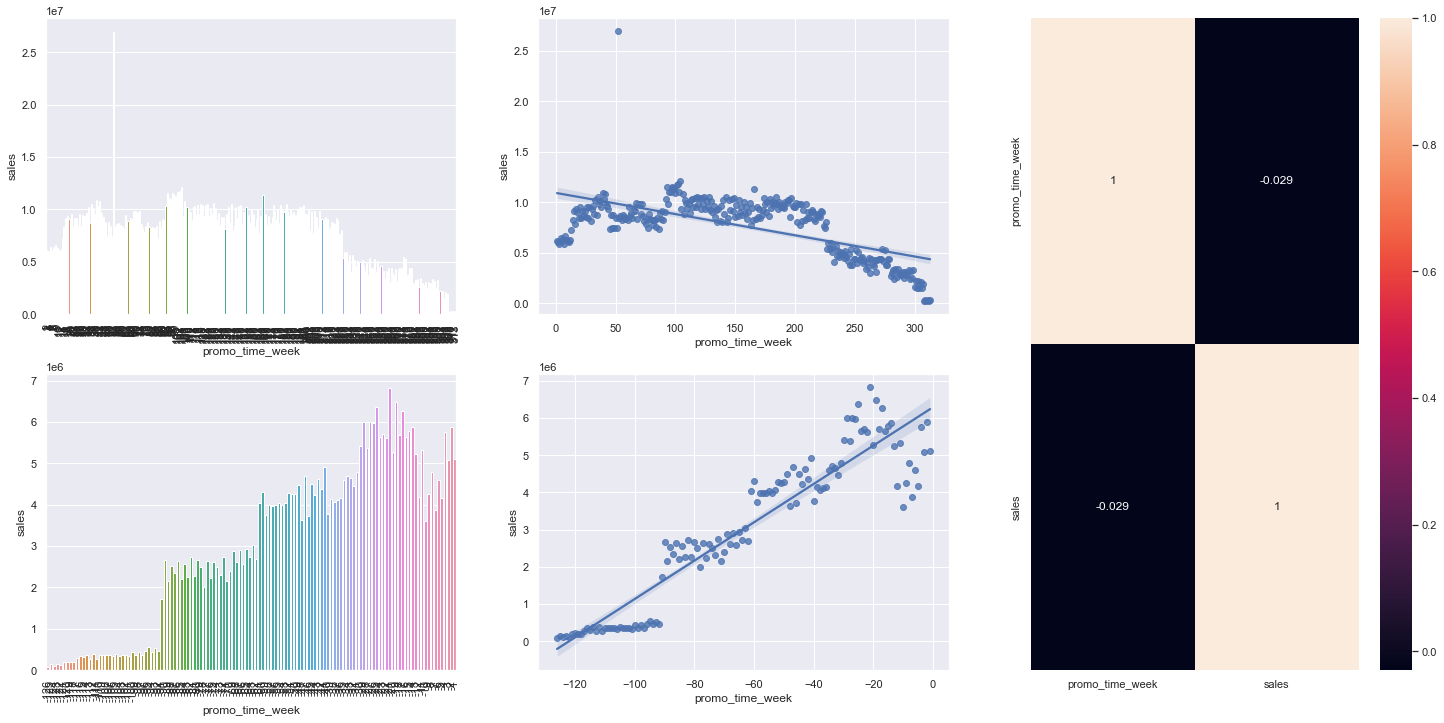

In [35]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week',y='sales',data=aux1)

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.regplot(x='promo_time_week',y='sales',data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

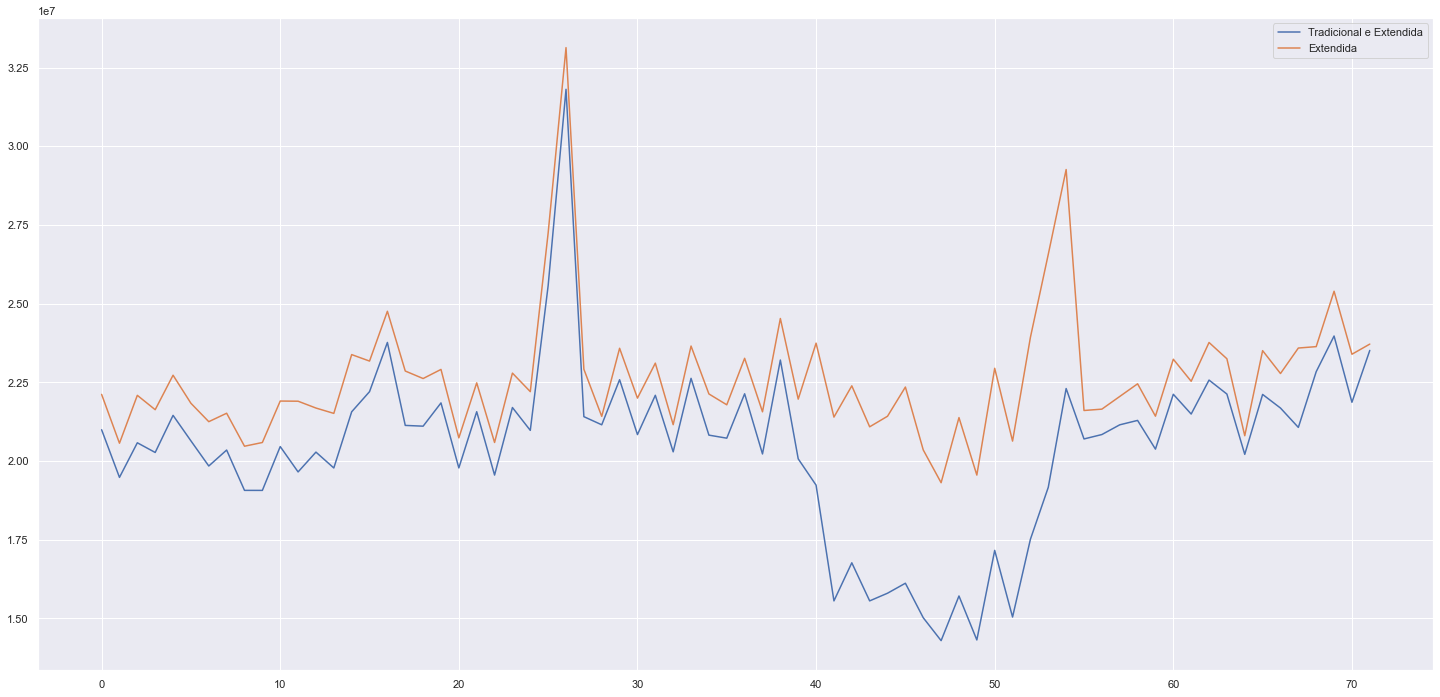

In [36]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

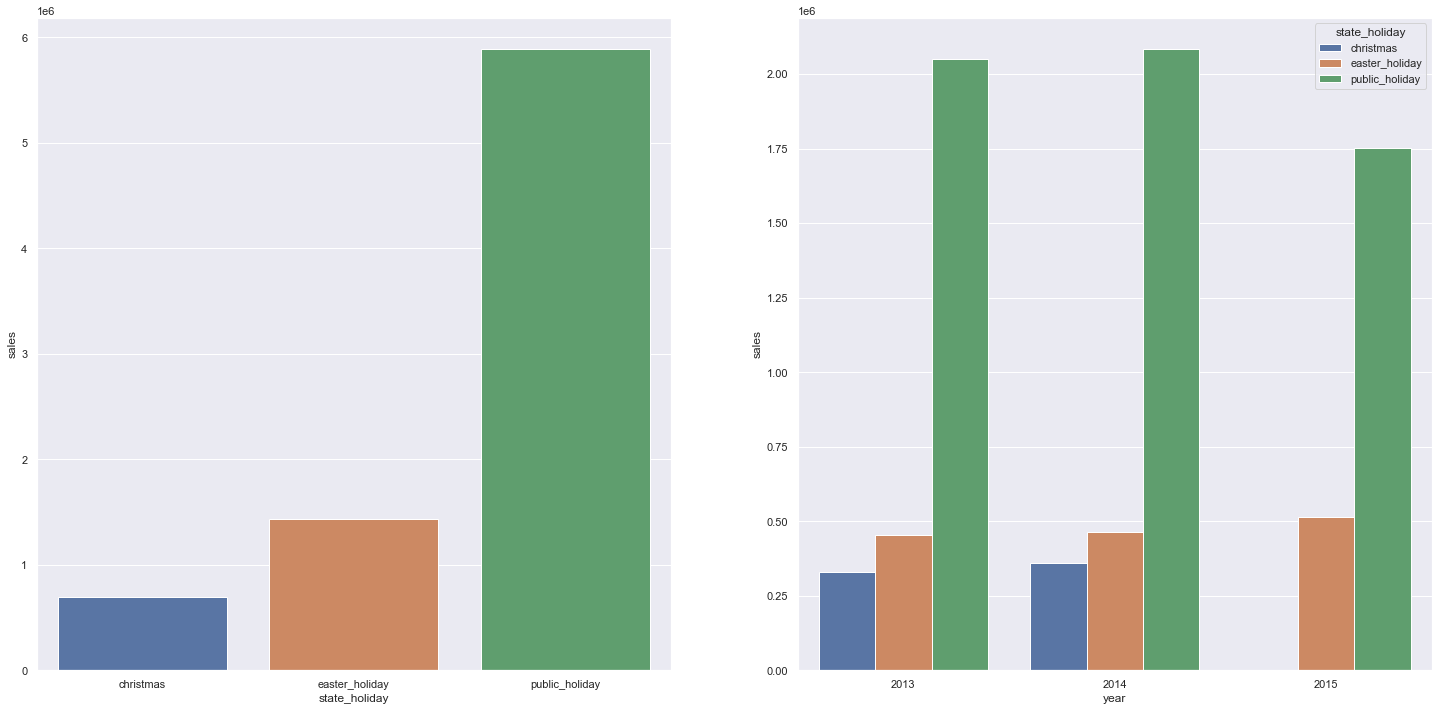

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',data=aux2, hue='state_holiday')

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**

<AxesSubplot:>

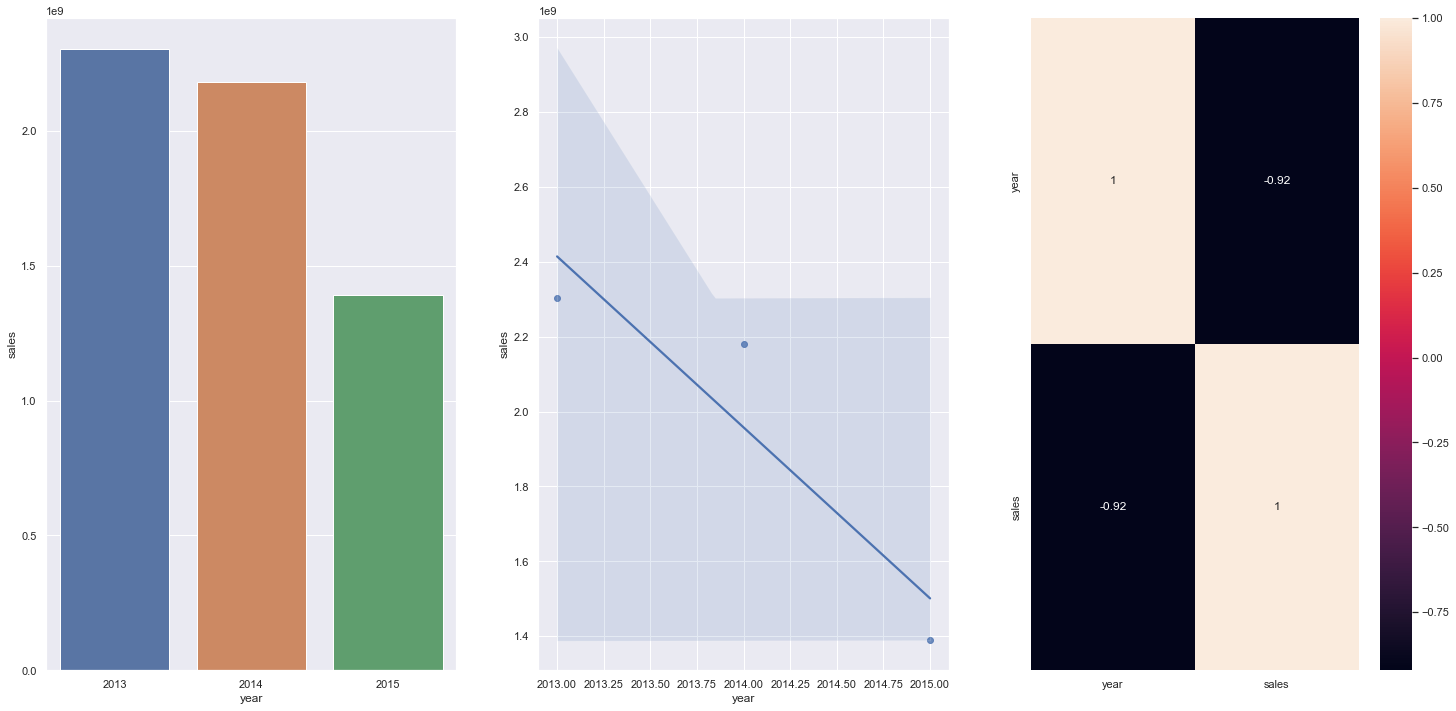

In [38]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.

<AxesSubplot:>

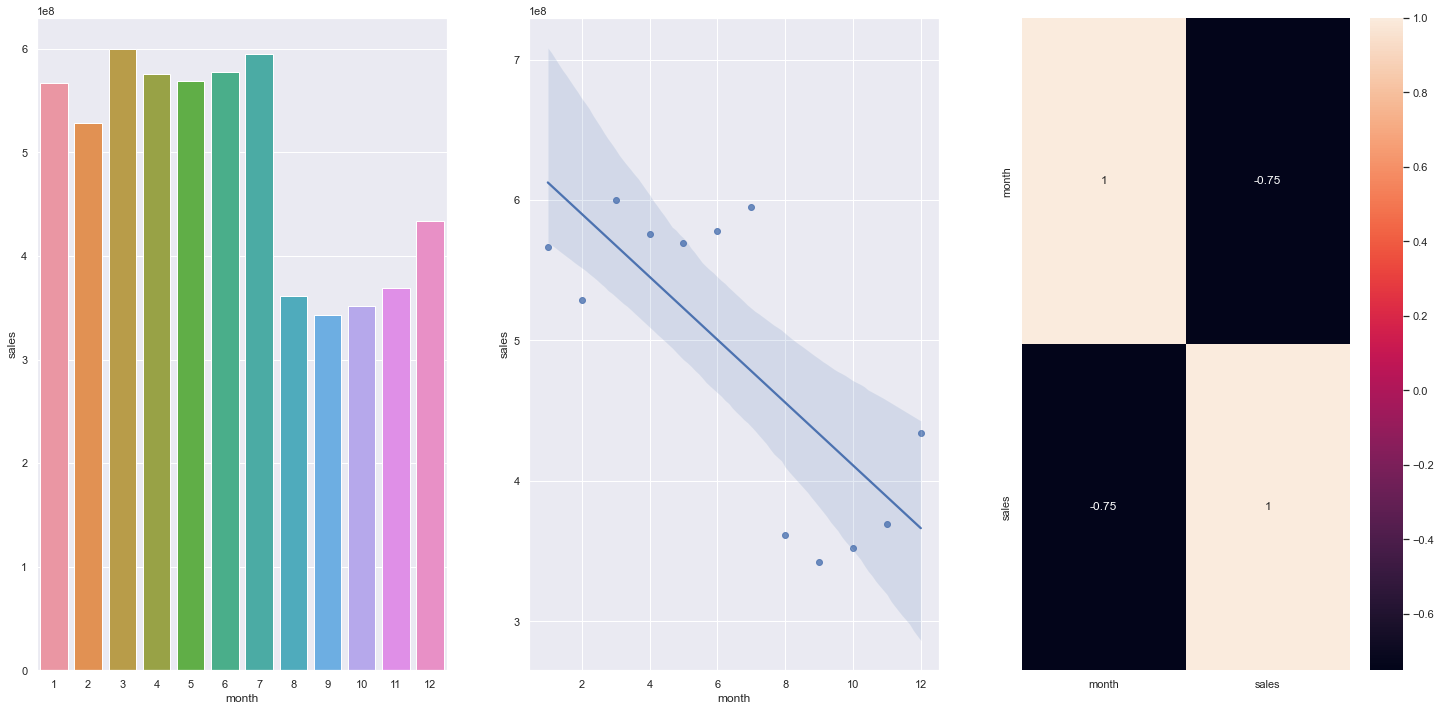

In [39]:
# df4['semester'] = df4['month'].apply(lambda x: 1 if x <= 6 else 2)
# aux1 = df4[['year','month','sales']].groupby(['year','month']).sum().reset_index()
# sns.barplot(x='month',y='sales',data=aux1, hue='year')

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

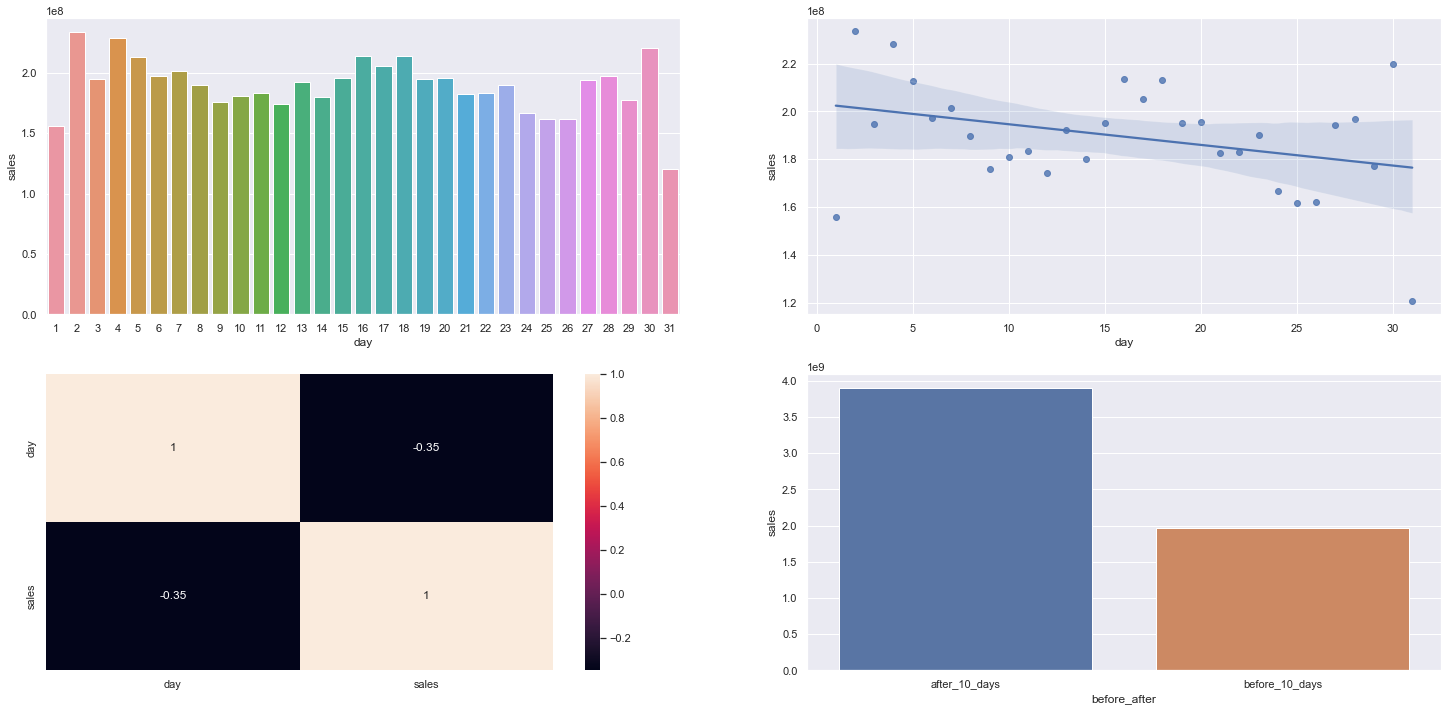

In [40]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index();
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2)

### H11. Lojas deveriam vender menos aos finais de semana.

<AxesSubplot:>

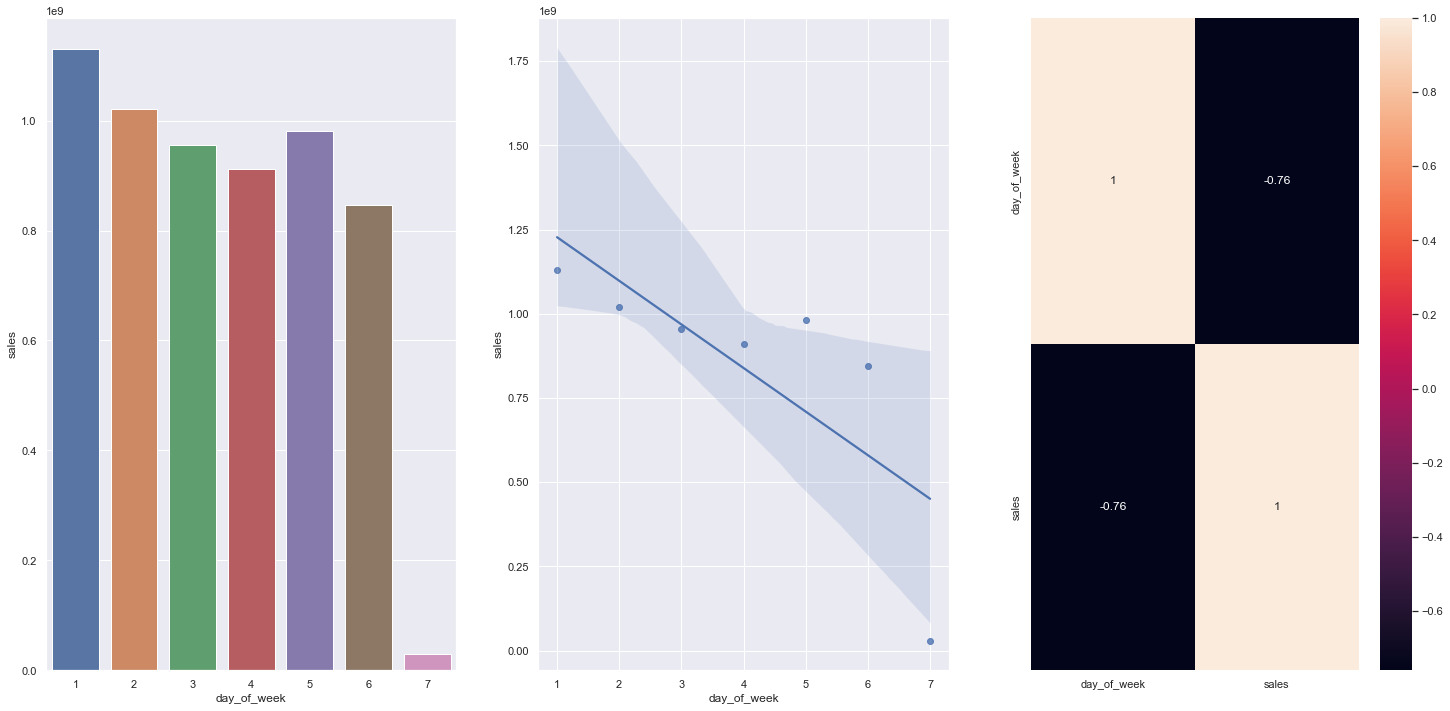

In [41]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

# aux1['weekend'] = aux1['day_of_week'].apply(lambda x: 1 if x > 5 else 0)
# aux2 = aux1[['weekend','sales']].groupby('weekend').sum().reset_index();
# plt.subplot(2,2,4)
# sns.barplot(x='weekend',y='sales',data=aux2)

### H12. Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

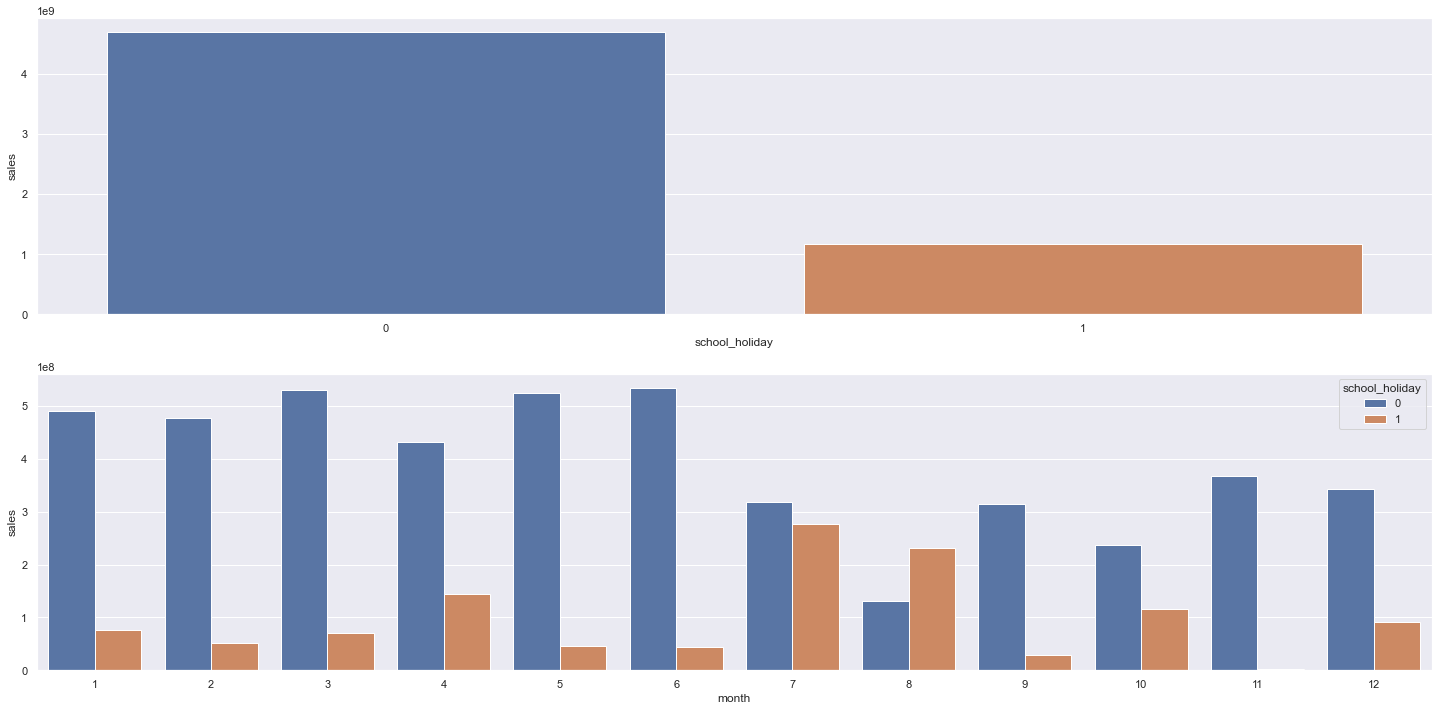

In [42]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1)

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2)

### 4.2.1 Resumo das Hipoteses

In [43]:
from tabulate import tabulate
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

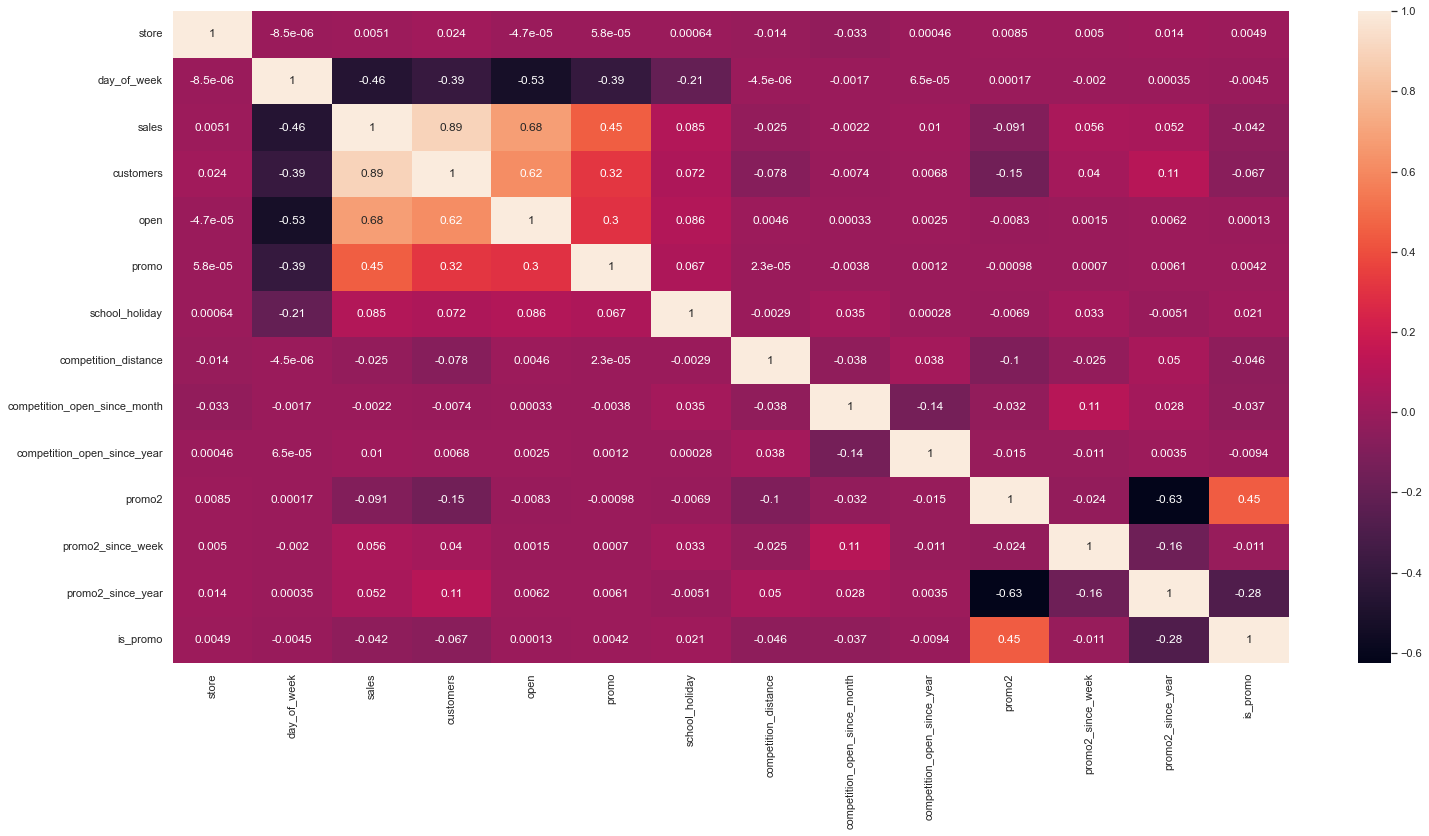

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

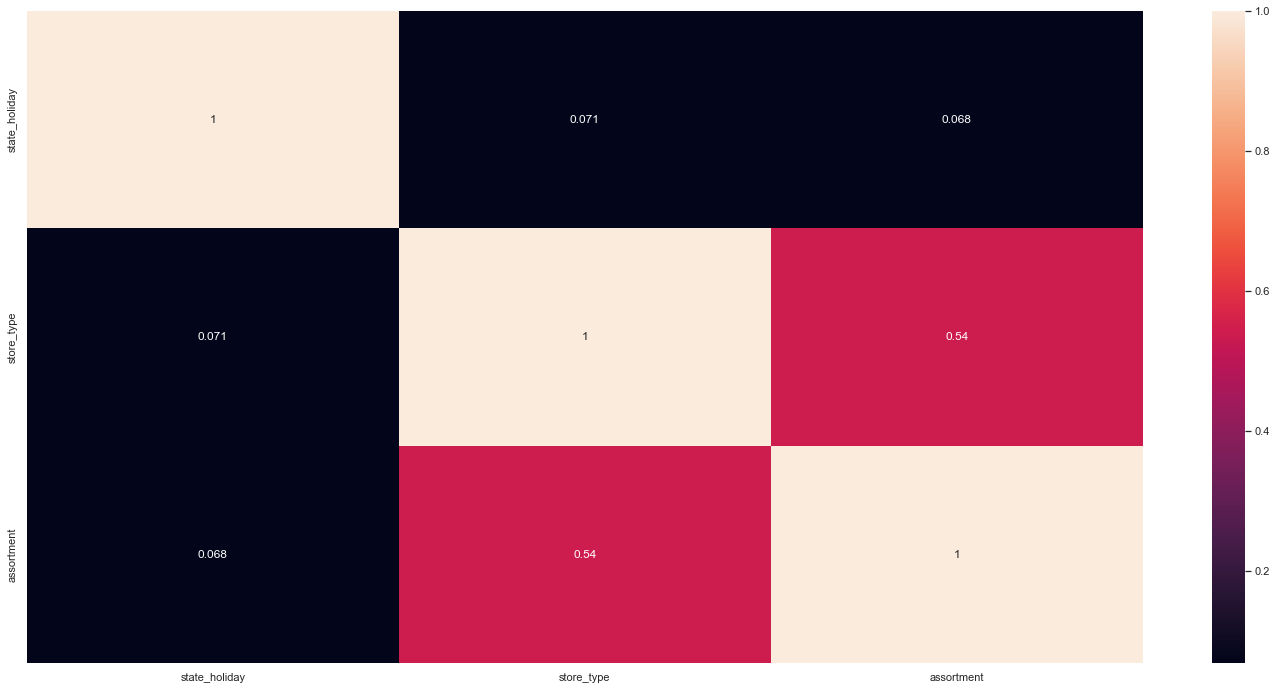

In [45]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])              

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame ({'state_holiday': [a1,a2,a3],
               'store_type':[a4,a5,a6],                            
               'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [141]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2 Rescaling

In [142]:
a = df5.select_dtypes(include=['int64','float64'])

In [143]:
rs = RobustScaler()
mms = MinMaxScaler()
# sns.boxplot(df5['competition_distance'])
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))


## 5.3 Transformacao

### 5.3.1 Encoding

In [140]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [51]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2 * np.pi/7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2 * np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2 * np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2 * np.pi/52)))

# 6.0 Feature Selection

In [52]:
df6 = df5.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split Dataframe into training and test dataset

In [53]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)
data_corte = df6['date'].max() - datetime.timedelta(days=42) # previsao 6 semanas
# training dataset
X_train = df6[df6['date'] < data_corte]
Y_train = X_train['sales']

# test datasets
X_test = df6[df6['date'] >= data_corte]
Y_test = X_test['sales']

## 6.2 Boruta Feature Selector

In [54]:
# # training and test dateset for boruta
# X_train_n = X_train.drop(['date','sales'], axis=1).values
# Y_train_n = Y_train.ravel()
# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs = -1)
# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1 Best Features from Boruta

In [55]:
# cols_selected = boruta.support_.tolist()
# X_train_fs = X_train.drop(['date','sales'],axis=1)
# cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3 Manual Feature Selection

In [66]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin', # adicionada manualmente
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin', # adicionada manualmente
 'week_of_year_cos']

 # columns to add
feat_to_add = ['date','sales']

 # final features
cols_selected_boruta_full =  cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


# 7.0 Machine Learning Modeling

In [57]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [58]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name:,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [59]:
# model
lr = LinearRegression().fit(x_train,Y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error ('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name:,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear regression Model - Cross Validation

In [87]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression',lr)
lr_result_cv

## 7.3 Linear Regression Regularized - Lasso

In [60]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, Y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name:,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [89]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso',lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [61]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train,Y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name:,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor - Cross Validation

In [90]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor',rf, True)
rf_result_cv

Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [62]:
# model
# parameters = {'objective':'reg:squarederror','eta':0.3,'max_depth':10,'subsample':1,'colsample_bytree':0.9}
# model_xgb = xgb.train(parameters,)
model_xgb = xgb.XGBRegressor(max_depth=10).fit( x_train, Y_train) 

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name:,MAE,MAPE,RMSE
0,XGBoost Regressor,678.860531,0.098461,994.270712


### 7.5.1 XGBoost Regressor - Cross Validation

In [91]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor',model_xgb,True)
xgb_result_cv

Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,919.46 +/- 187.04,0.13 +/- 0.02,1315.87 +/- 265.07


## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [63]:
modeling_result = pd.concat([baseline_result,lr_result,lrr_result, rf_result,xgb_result])
modeling_result.sort_values('RMSE')

,Model Name:,MAE,MAPE,RMSE
0,XGBoost Regressor,678.860531,0.098461,994.270712
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [92]:
modeling_result_cv =  pd.concat([lr_result_cv,lrr_result_cv, rf_result_cv,xgb_result_cv])
modeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,919.46 +/- 187.04,0.13 +/- 0.02,1315.87 +/- 265.07


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [99]:
# param = {
#     'n_estimators':[100,500,1000,2000,3000],
#     'eta': [0.1,0.3,0.5,0.8],
#     'max_depth':[3,6,9,12],
#     'subsample':[0.2,0.5,0.7,1],
#     'colsample_bytree':[0.3,0.7,1],
#     'min_child_weight':[0.5,1,3,5]
# }

# MAX_EVAL = 10

In [100]:

# # model
# # parameters = {'objective':'reg:squarederror','eta':0.3,'max_depth':6,'subsample':1,'colsample_bytree':1, min_child_weight:1}
# # model_xgb = xgb.train(parameters,)
# # model_xgb = xgb.XGBRegressor(max_depth=10).fit( x_train, Y_train) 
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = { k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)

#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#     n_estimators=hp['n_estimators'], 
#     eta=hp['eta'], 
#     max_depth=hp['max_depth'],
#     subsample=hp['subsample'], 
#     colsample_bytree=hp['colsample_bytree'],
#     min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation( x_training,5,'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat([final_result,result])

# final_result

{'n_estimators': 3000, 'eta': 0.5, 'max_depth': 3, 'subsample': 1, 'colsample_bytree': 1, 'min_child_weight': 1}
Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1
{'n_estimators': 1000, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 1, 'min_child_weight': 3}
Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1
{'n_estimators': 2000, 'eta': 0.5, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 0.5}
Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1
{'n_estimators': 500, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.2, 'colsample_bytree': 1, 'min_child_weight': 1}
Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1
{'n_estimators': 100, 'eta': 0.8, 'max_depth': 3, 'subsample': 0.2, 'colsample_bytree': 0.3, 'min_child_weight': 5}
Kfold number: 5
Kfold number: 4
Kfold number: 3
Kfold number: 2
Kfold number: 1
{'n_estimators': 1000, 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,967.23 +/- 156.17,0.14 +/- 0.02,1375.52 +/- 227.5
0,XGBoost Regressor,1225.27 +/- 130.73,0.17 +/- 0.01,1763.14 +/- 165.88
0,XGBoost Regressor,1169.44 +/- 180.34,0.16 +/- 0.02,1659.68 +/- 259.4
0,XGBoost Regressor,975.55 +/- 139.89,0.14 +/- 0.01,1394.77 +/- 192.86
0,XGBoost Regressor,1512.98 +/- 185.75,0.21 +/- 0.01,2149.21 +/- 242.49
0,XGBoost Regressor,1222.92 +/- 344.94,0.17 +/- 0.05,1744.71 +/- 431.57
0,XGBoost Regressor,1060.85 +/- 188.61,0.15 +/- 0.02,1496.78 +/- 260.84
0,XGBoost Regressor,1048.57 +/- 158.47,0.15 +/- 0.02,1481.88 +/- 215.07
0,XGBoost Regressor,1052.15 +/- 126.93,0.15 +/- 0.01,1495.33 +/- 167.91
0,XGBoost Regressor,1126.24 +/- 165.09,0.16 +/- 0.02,1583.61 +/- 222.0


## 8.2 Final Model

In [102]:
param_tuned = {
    'n_estimators':2000,
    'eta':0.3 ,
    'max_depth':10,
    'subsample':1,
    'colsample_bytree':1,
    'min_child_weight':1
}

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
    n_estimators=param_tuned['n_estimators'], 
    eta=param_tuned['eta'], 
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'], 
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']).fit(x_train,Y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name:,MAE,MAPE,RMSE
0,XGBoost Regressor,695.726086,0.101241,1002.914284


In [119]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

0.007057045100340874

# 9.0 Traducao e Interpretacao do Erro

In [121]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\gusta\AppData\Local\Temp\ipykernel_14476\403577207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\gusta\AppData\Local\Temp\ipykernel_14476\403577207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Business Performance

In [125]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9aux3 = pd.merge(df9aux1,df9aux2, how='inner', on='store')
df92 = pd.merge(df91, df9aux3, how='inner',on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df92.sample(20)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
841,842,676749.687500,673832.871780,679666.503220,2916.815720,0.139161
1103,1104,205974.000000,205454.091229,206493.908771,519.908771,0.098952
398,399,221503.984375,220893.653782,222114.314968,610.330593,0.101438
357,358,374916.468750,374279.030669,375553.906831,637.438081,0.068262
667,668,319957.312500,319371.828943,320542.796057,585.483557,0.068317
833,834,209410.812500,208904.305189,209917.319811,506.507311,0.087448
867,868,342618.468750,341566.528122,343670.409378,1051.940628,0.106297
570,571,295051.562500,294087.551428,296015.573572,964.011072,0.112573
467,468,199879.921875,198861.609164,200898.234586,1018.312711,0.147524
723,724,265155.343750,264556.267459,265754.420041,599.076291,0.098405


In [126]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107961.500000,104578.463482,111344.536518,3383.036518,0.573093
908,909,255016.484375,247630.558360,262402.410390,7385.926015,0.526835
182,183,231684.765625,229632.827211,233736.704039,2051.938414,0.352567
875,876,207092.218750,203263.988621,210920.448879,3828.230129,0.289356
549,550,245235.734375,243772.055981,246699.412769,1463.678394,0.279546


<AxesSubplot:xlabel='store', ylabel='MAPE'>

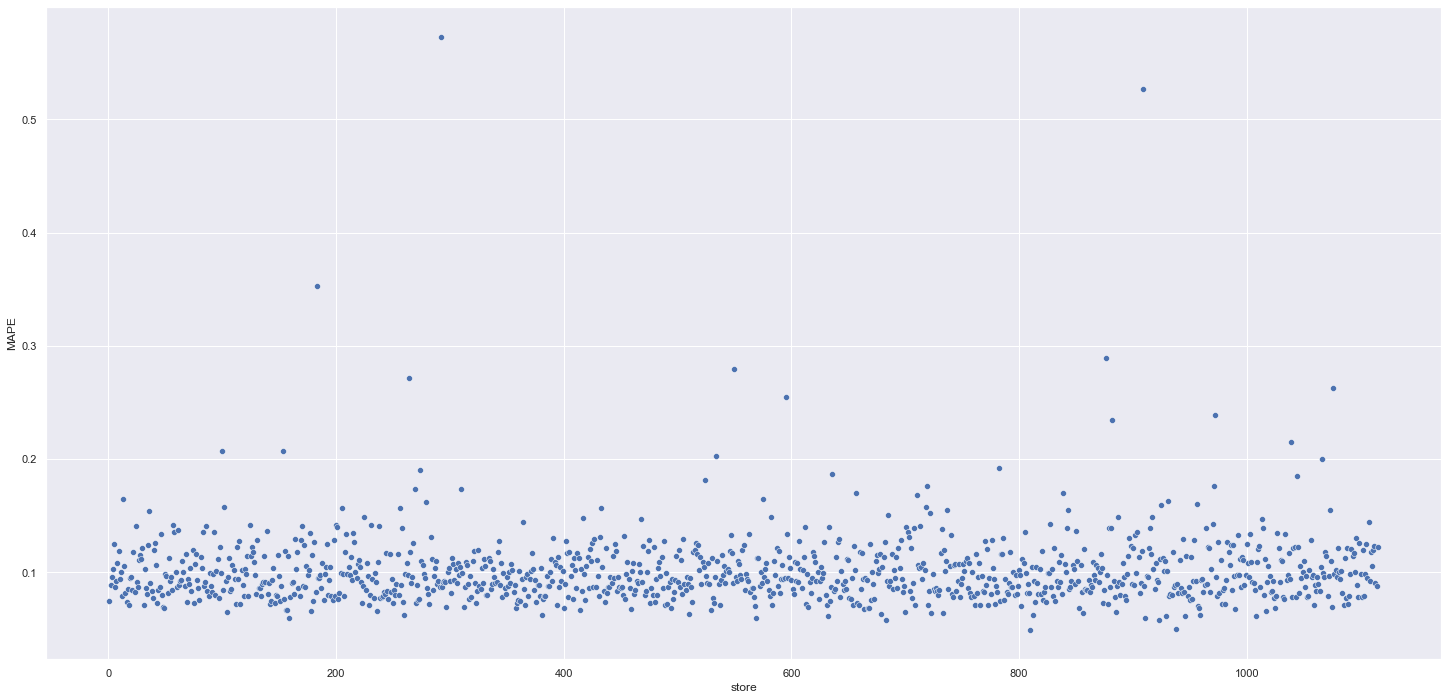

In [127]:
sns.scatterplot(x='store',y='MAPE', data=df92)

## 9.2 Total Performance

In [130]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

,Scenario,values
0,predictions,"R$283,894,272.00"
1,worst_scenario,"R$283,114,997.05"
2,best_scenario,"R$284,673,566.80"


## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\gusta\anaconda3\envs\rossman\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gusta\anaconda3\envs\rossman\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

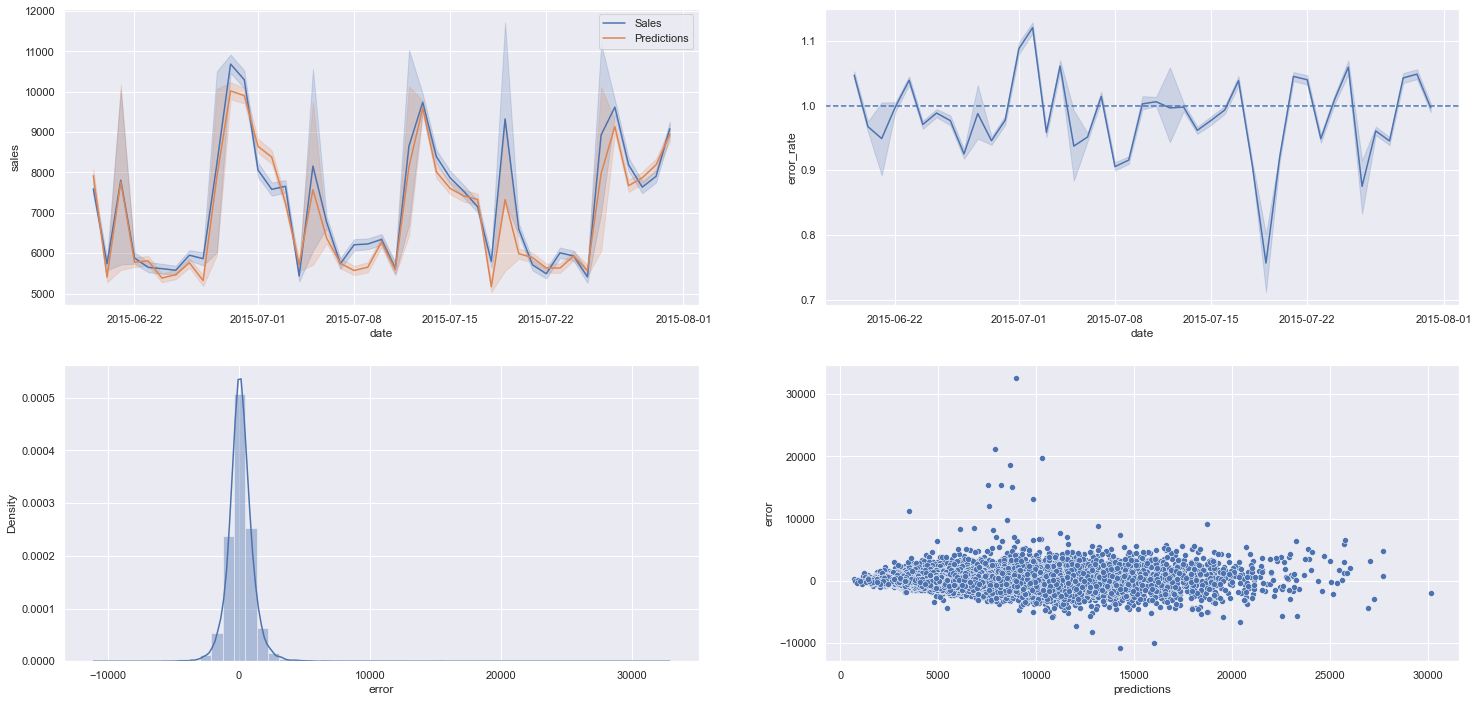

In [133]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 Deploy Model to Production

In [ ]:
# Save trained model
pickle.dump(model_xgb_tuned, open ('model/model_rossman.pkl','wb'))

## 10.1 Rossman Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/gusta/Repos_Git/rossman/'
        self.competition_distance_scaler =   pickle.load(open (self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open (self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler =        pickle.load(open (self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler =                   pickle.load(open (self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.store_type_scaler =             pickle.load(open (self.home_path + 'parameter/store_type_scaler.pkl','rb'))

    def data_cleaning(self,df1):

        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        # 1.5 Fillout NA
        #competition distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        #promo_interval
        month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        return df1
    
    def feature_enginnering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        # 3.0 Filtragem de variaveis
        ## 3.1 Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        ## 3.2 Selecao de Colunas
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        return df2

    def data_preparation(self, df5):        
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformacao
        ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])   
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        ### 5.3.3 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2 * np.pi/7)))
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2 * np.pi/12)))
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2 * np.pi/30)))
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2 * np.pi/52)))

        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                        'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                        'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']


        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data)

        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json( orient='records', date_format='iso')


## 10.2 API Handler

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossman import Rossmann

#loading model
model = pickle.load(open('model/model_rossman.pkl','rb'))
app = Flask( __name__)

app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):#unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) 

        #instantiate rossman class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature enginnering
        df2 = pipeline.feature_enginnering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 API Tester

In [158]:
# loading test dataset
df10 = pd.read_csv('datasets/test.csv')
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin(range(50))]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'https://gf-rossmann-model.herokuapp.com/rossmann/predict'
header = {'Content_type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [159]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,1,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,basic,1270.0,9,2008,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2008-09-01T00:00:00.000Z,85,2015-09-14T00:00:00.000Z,0,4814.844727
1,3,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2006-12-01T00:00:00.000Z,107,2011-03-28T00:00:00.000Z,233,9164.723633
2,7,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,24000.0,4,2013,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2013-04-01T00:00:00.000Z,29,2015-09-14T00:00:00.000Z,0,4532.915039
3,8,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,7520.0,10,2014,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2014-10-01T00:00:00.000Z,11,2015-09-14T00:00:00.000Z,0,6645.828613
4,9,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,2030.0,8,2000,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2000-08-01T00:00:00.000Z,184,2015-09-14T00:00:00.000Z,0,6906.654785


In [160]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediction']))

Store number 1 will sell $216,942.37 in the next 6 weeks
Store number 3 will sell $328,185.61 in the next 6 weeks
Store number 7 will sell $253,452.61 in the next 6 weeks
Store number 8 will sell $245,045.50 in the next 6 weeks
Store number 9 will sell $268,517.37 in the next 6 weeks
Store number 10 will sell $214,104.15 in the next 6 weeks
Store number 11 will sell $300,140.37 in the next 6 weeks
Store number 12 will sell $278,229.75 in the next 6 weeks
Store number 13 will sell $195,632.17 in the next 6 weeks
Store number 14 will sell $229,929.59 in the next 6 weeks
Store number 15 will sell $281,007.85 in the next 6 weeks
Store number 16 will sell $304,823.65 in the next 6 weeks
Store number 19 will sell $275,446.54 in the next 6 weeks
Store number 20 will sell $292,247.84 in the next 6 weeks
Store number 21 will sell $336,391.27 in the next 6 weeks
Store number 22 will sell $172,207.23 in the next 6 weeks
Store number 23 will sell $237,347.71 in the next 6 weeks
Store number 24 wil